# 0. Importing Libraries

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import urllib

import numpy as np

import os
import time

In [2]:
# Open the shapefile containing data (.shp)
dataframe = gpd.read_file('data/FEUX_PT_ORI_1972_2021.shp')

In [3]:
# show first rows
dataframe.head()

,CLE,ANNEE,NOFEU,SECTION,CAUSE,DATE_DEBUT,DATE_RAPPO,DATE_ETEIN,SUP_HA,LATITUDE,LONGITUDE,geometry
0,1.972101e+10,1972,1001,Intensive,Humaine,1972-05-17,1972-05-17,1972-05-17,0.0,49.20444,-65.74036,POINT (200020.171 581894.784)
1,1.972101e+10,1972,1002,Intensive,Humaine,1972-05-22,1972-05-23,1972-05-24,0.2,48.75719,-67.45225,POINT (76682.274 529102.019)
2,1.972101e+10,1972,1003,Intensive,Humaine,1972-05-22,1972-05-23,1972-05-27,8.5,48.60762,-67.56837,POINT (68399.806 512427.707)
3,1.972101e+10,1972,1004,Intensive,Humaine,1972-05-23,1972-05-23,1972-05-24,0.1,48.84772,-67.20080,POINT (94901.540 539422.945)
4,1.972101e+10,1972,1005,Intensive,Humaine,1972-05-23,1972-05-23,1972-05-23,0.0,49.10402,-64.73214,POINT (273622.775 574131.313)


In [4]:
# number of wildfires by cause
dataframe['CAUSE'].value_counts()

Humaine    30922
Foudre     11869
Name: CAUSE, dtype: int64

In [5]:
# export data to a more convenient file format (.csv)
dataframe.to_csv("data.csv", index=False)

In [6]:
# selecting important columns
df_new = dataframe.loc[:, ['CLE', 'DATE_DEBUT', 'SUP_HA', 'LATITUDE', 'LONGITUDE']]

# renaming columns
df_new.rename(columns={"CLE": "id",
                        "DATE_DEBUT": "date",
                        "SUP_HA": "acres",
                        "LATITUDE": "lat",
                        "LONGITUDE": "lon"}, inplace = True)

# Formatting the date using pandas
df_new.date = pd.to_datetime(df_new.date).dt.strftime('%m/%d/%Y')
df_new['date'] = pd.to_datetime(df_new.date)

# For {lon,lat} coordinates in the URL
df_new['lon'] = df_new['lon'].map(lambda x: str(x))
df_new['lat'] = df_new['lat'].map(lambda x: str(x))
df_new['coords'] = df_new[['lon', 'lat']].agg(','.join, axis=1)

# infos about the new dataframe
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42791 entries, 0 to 42790
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      42791 non-null  float64       
 1   date    42790 non-null  datetime64[ns]
 2   acres   42791 non-null  float64       
 3   lat     42791 non-null  object        
 4   lon     42791 non-null  object        
 5   coords  42791 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 2.0+ MB


In [7]:
# first rows
df_new.head()

,id,date,acres,lat,lon,coords
0,1.972101e+10,1972-05-17,0.0,49.20444,-65.74036,"-65.74036,49.20444"
1,1.972101e+10,1972-05-22,0.2,48.75719,-67.45225,"-67.45225,48.75719"
2,1.972101e+10,1972-05-22,8.5,48.60762,-67.56837,"-67.56837,48.60762"
3,1.972101e+10,1972-05-23,0.1,48.84772,-67.2008,"-67.2008,48.84772"
4,1.972101e+10,1972-05-23,0.0,49.10402,-64.73214,"-64.73214,49.10402"


In [8]:
# remove duplicates based on position on map
df_new = df_new.drop_duplicates(subset='coords')
# remove 0 acres-burned wildfires
df_new = df_new[df_new.acres != 0]
# shuffle & reset index
df_new = df_new.sample(frac = 1).reset_index(drop = True)

In [9]:
# new data after preprocessing
df_new.head()

,id,date,acres,lat,lon,coords
0,1.978101e+10,1978-11-03,5.5,47.6292,-68.996,"-68.996,47.6292"
1,2.020108e+10,2020-05-23,0.3,46.9475,-71.3518,"-71.3518,46.9475"
2,2.012108e+10,2012-05-23,11.0,48.1667,-77.57,"-77.57,48.1667"
3,1.995108e+10,1995-09-05,0.5,48.98412,-73.33445,"-73.33445,48.98412"
4,1.976101e+10,1976-05-30,3.9,48.85761,-67.46309,"-67.46309,48.85761"


# Collecting Satellite Images

Total data : 24686(wildfire) + 22000(nowildfire) = 46686

- Train (70%): 17280(wf) + 15400(nwf) = 32680
- Validation (15%): 3703(wf) + 3300(nwf) = 7003
- Test (15%): 3703(wf) + 3300(nwf) = 7003

 (we'll be deleting manually some irrelevant data)

In [10]:
# api key to get satellite images using mapbox API
api_key = open('api_key_mapbox.txt', 'r').read()

img_size = '350x350'

img_format = '.jpg'

zoom = '15'

In [11]:
# Splitting the URL
base_link = 'https://api.mapbox.com/styles/v1/mapbox/satellite-v9/static/'

# Creating what's left for the URL:
token = '?access_token='

extra =  '&logo=false&attribution=false'


rest = ',' + zoom + ',0/' + img_size + token + api_key + extra
# URL = base_link + row['coords'] + rest

In [12]:
for index, row in df_new.iterrows():
    if index < 17280:
        path = "data/images/train/wildfire/"
    elif index < 20983:
        path = "data/images/valid/wildfire/"
    else:
        path = "data/images/test/wildfire/"
    
    if (not os.path.isfile(path + row['coords'] + img_format)):
        url = base_link + row['coords'] + rest
        urllib.request.urlretrieve(url, path
                                        + row['coords']
                                        + img_format)

"No wildfire" images

In [13]:
# urban areas in Canada (no wildfire)
lonLatPairs = [[-73.919586,45.397682,-73.408447,45.644191], # Montréal
               [-75.832169,45.324615,-75.565064,45.472230], # Ottawa
               [-79.746048,43.624743,-79.244522,43.916313], # Toronto
               [-123.200409,49.095047,-122.717560,49.271477], # Vancouver
               [-114.174042,50.894499,-113.917236,51.174454]] # Calgary

nowildfire_size = 22000
new_lats = []
new_lons = []

# same random generator
rs = np.random.RandomState(42)

for pair in lonLatPairs:
    lats = rs.uniform(low = pair[1], 
                             high = pair[3], 
                             size = (int(nowildfire_size/5),))

    lons = rs.uniform(low = pair[0], 
                             high = pair[2], 
                             size = (int(nowildfire_size/5),))
    
    new_lats.extend(lats)
    new_lons.extend(lons)

In [14]:
df_nowf = pd.DataFrame(data={'lat':new_lats, 'lon': new_lons})

# rounding floats
df_nowf['lat'] = df_nowf['lat'].map(lambda x: round(x, 6))
df_nowf['lon'] = df_nowf['lon'].map(lambda x: round(x, 6))

# For {lon,lat} coordinates in the URL
df_nowf['lat'] = df_nowf['lat'].map(lambda x: str(x))
df_nowf['lon'] = df_nowf['lon'].map(lambda x: str(x))
df_nowf['coords'] = df_nowf[['lon', 'lat']].agg(','.join, axis=1)

# Shuffle & reset index
df_nowf = df_nowf.sample(frac = 1, random_state = rs).reset_index(drop = True)
df_nowf.head()

,lat,lon,coords
0,43.680424,-79.497188,"-79.497188,43.680424"
1,45.378369,-75.760943,"-75.760943,45.378369"
2,49.125911,-122.90858,"-122.90858,49.125911"
3,45.506026,-73.854857,"-73.854857,45.506026"
4,43.791904,-79.745792,"-79.745792,43.791904"


In [15]:
for index, row in df_nowf.iterrows():
    if index < 15400:
        path = "data/images/train/nowildfire/"
    elif index < 18700:
        path = "data/images/valid/nowildfire/"
    else:
        path = "data/images/test/nowildfire/"
    
    if (not os.path.isfile(path + row['coords'] + img_format)):
        url = base_link + row['coords'] + rest
        urllib.request.urlretrieve(url, path
                                        + row['coords']
                                        + img_format)

#### After cleaning and removing some irrelevant data (since we are retrieving some old firespots "1972-"), we are left with these numbers

- train = 30250 imgs = 70.6%
- valid = 6300  imgs = 14.7%
- test  = 6300  imgs = 14.7%

- wf = 52.0% / nwf = 48.0% #train# wf = 15750 / nwf = 14500
- wf = 52.2% / nwf = 47.8% #valid# wf = 3480  / nwf = 2820
- wf = 52.2% / nwf = 47.8% #valid# wf = 3480  / nwf = 2820

- - wf  = 22710 = 53%
- - nwf = 20140 = 47%

Showing some examples

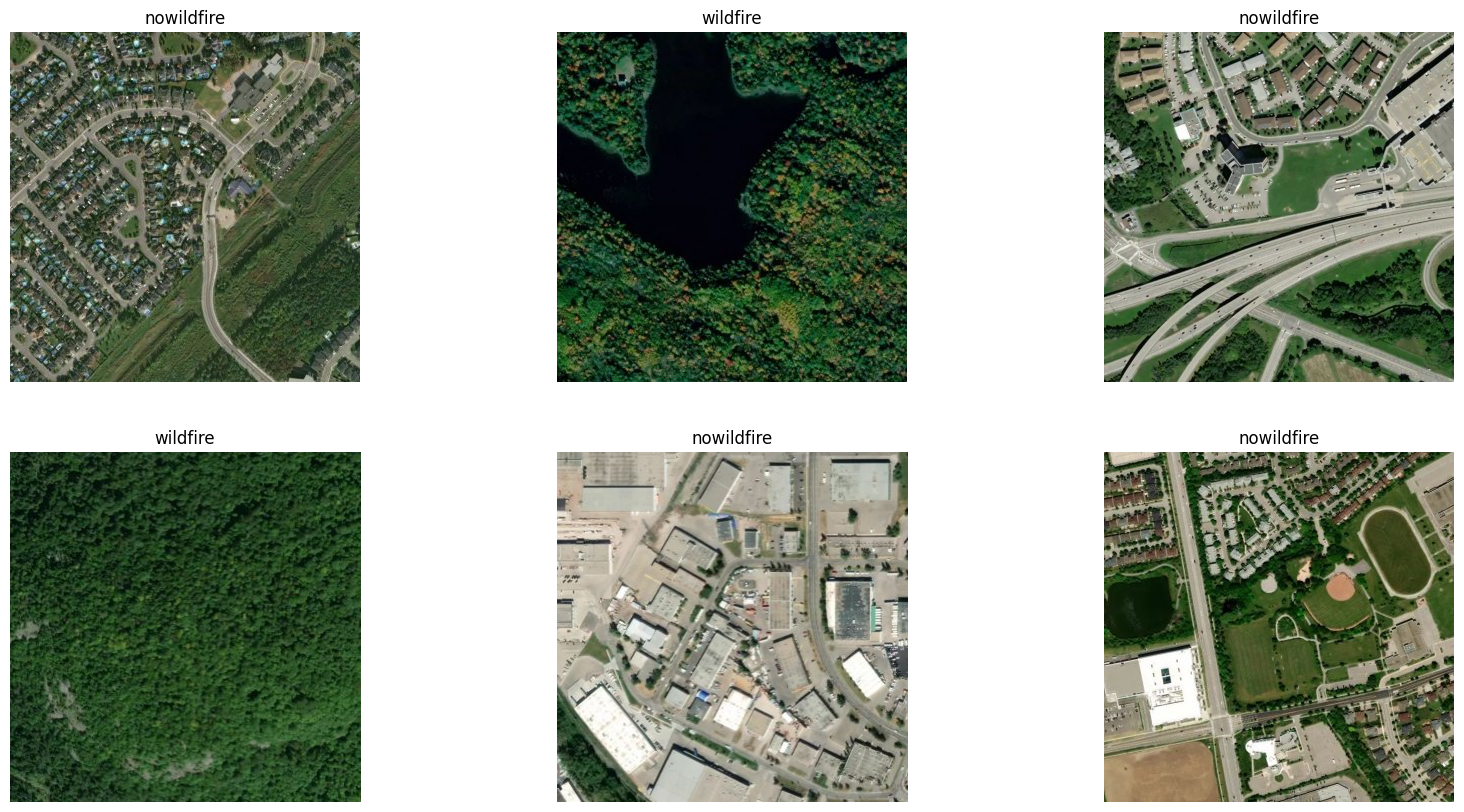

In [32]:
from PIL import Image

class_names=['wildfire', 'nowildfire']

# creating a figure to plot the images on
fig = plt.figure(figsize = (20, 10))

for i in range(6):
    class_name = np.random.choice(class_names)
    imgname = f"./data/images/train/{class_name}/" + np.random.choice(os.listdir(f"./data/images/train/{class_name}/"))
    img = Image.open(imgname)
    ax = fig.add_subplot(2,3,i+1,xticks = [], yticks = [])
    ax.imshow(img)
    plt.axis('off')
    plt.title(class_name)